In [1]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
pd.options.display.max_columns=None

import numpy as np

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import pickle


In [312]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project="foot_LSTM_only_with_regularization", entity="padda")

In [3]:
def cm_metrics(true_label,pred_label, labels_):
  cm = confusion_matrix(true_label,pred_label,labels = labels_)
  cmDisp = ConfusionMatrixDisplay(cm,display_labels=labels_)
  recall = { i:cm[i][i]/cm[i].sum()  for i in range(len(cm))}
  precision = { i:cm[i][i]/cm[:,i].sum()  for i in range(len(cm))}
  F1_score = { i: 2 / (1/recall[i] + 1/precision[i]) for i in range(len(cm))}
  accuracy = (cm[0][0]+cm[1][1]+cm[2][2])/cm.sum()
  print('accuracy: ', accuracy)
  print('Recall: \n',recall,'\nPrecision: \n', precision,'\nF1-score: \n',F1_score)
  cmDisp.plot()
  plt.show()
  return None

In [4]:
home_history = pd.read_csv('../data/train_LSTM/home_history_full.csv', index_col = 0,\
    dtype={'home_id' : np.int32, 'game_id' : np.int32, 'H_goals' : np.int8, 'H_goals_conceded' : np.int8,\
         'H_HorA' : np.int8, 'H_yellow_cards' : np.int8, 'H_red_cards' : np.int8}\
    )

In [5]:
away_history = pd.read_csv('../data/train_LSTM/away_history_full.csv', index_col = 0,\
    dtype={'away_id' : np.int32, 'game_id' : np.int32, 'A_goals' : np.int8, 'A_goals_conceded' : np.int8,\
         'A_HorA' : np.int8, 'A_yellow_cards' : np.int8, 'A_red_cards' : np.int8}\
    )

In [6]:
games = pd.read_csv('../../data/games/games.csv',\
        usecols=['game_id','home_club_id', 'away_club_id','home_club_goals', 'away_club_goals'],\
        dtype = {'game_id' : np.int32, 'home_club_id' : np.int32, 'away_club_id' : np.int32,\
                'home_club_goals' : np.int8, 'away_club_goals' : np.int8})

In [7]:
#ATTENTION: certaines parties apparaissent en double dans games.csv
tt = home_history.groupby('game_id')['home_id'].count().reset_index()
display(tt.loc[tt.home_id==20,:])
# ça nous casse les pieds on va s'en débarasser, il n'y en a que trois, on les jarte
home_history.drop(home_history.loc[home_history.game_id.isin( tt.loc[tt.home_id>10,'game_id'] ), :].index,inplace = True)


#idem pour away_history

tt = away_history.groupby('game_id')['away_id'].count().reset_index()
display(tt.loc[tt.away_id==20,:])
away_history.drop(away_history.loc[away_history.game_id.isin( tt.loc[tt.away_id>10,'game_id'] ), :].index,inplace = True)


,game_id,home_id
37318,3631969,20
37427,3646046,20
37432,3646057,20


,game_id,away_id
38030,3631968,20
38141,3646046,20
38146,3646057,20


In [237]:
games.head(1)

,game_id,home_club_id,away_club_id,home_club_goals,away_club_goals,home_result
0,2457642,1269,610,1,0,0


In [8]:

# on rajoute des 0 et des 1 au début de chaque ligne pour indiquer si il y a un match ou pas
# on inverse le game_history avec np.flip(game_history,axis=1) pour classer les matches du plus ancien au plus récent
# Cela dit l'expérience montre que cette inversion n'a pas énormément d'impact sur les performances du modèle... 

def make_home_train(game_id):
    game_history = home_history.loc[home_history.game_id == game_id,:].drop(columns=['home_id','game_id'])
    if (n_lines := game_history.shape[0]) == 0:
        return np.zeros((10,6)).astype(np.int8)
    else:
        return np.vstack(( np.zeros((10-n_lines,6)) , np.hstack(( np.ones((n_lines,1)) , np.flip(game_history.to_numpy(),axis=1))) )).astype(np.int8)

In [9]:
train_home = games.game_id.progress_apply(make_home_train)
train_home = np.stack(train_home.values)

100%|██████████| 42592/42592 [00:43<00:00, 989.51it/s] 


In [11]:
def make_away_train(game_id):
    game_history = away_history.loc[away_history.game_id == game_id,:].drop(columns=['away_id','game_id'])
    if (n_lines := game_history.shape[0]) == 0:
        return np.zeros((10,6)).astype(np.int8)
    else:
        return np.vstack(( np.zeros((10-n_lines,6)) , np.hstack(( np.ones((n_lines,1)) , np.flip(game_history.to_numpy(),axis=1))) )).astype(np.int8)

train_away = games.game_id.progress_apply(make_away_train)
train_away = np.stack(train_away.values)

100%|██████████| 42592/42592 [00:44<00:00, 955.93it/s] 


In [14]:
games['home_result'] = games.apply(lambda x : 0 if x['home_club_goals'] > x['away_club_goals']\
    else ( 1 if x['home_club_goals'] == x['away_club_goals'] else 2)  \
    , axis = 1)

In [15]:
train_away.shape, train_home.shape, games.home_result.shape

((42592, 10, 6), (42592, 10, 6), (42592,))

In [323]:
X = np.stack((train_away, train_home))
y = games.home_result.values
XH_train, XH_test, XA_train, XA_test, y_train, y_test = train_test_split(train_home, train_away, y, test_size = 0.25, random_state=0, stratify=y)

In [324]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, xh_data, xa_data, y_data, batch_size):
    self.xh,self.xa, self.y = xh_data, xa_data, y_data
    self.batch_size = batch_size
    self.num_batches = np.ceil(len(xh_data) / batch_size)
    self.batch_idx = np.array_split(range(len(xh_data)), self.num_batches)

  def __len__(self):
    return len(self.batch_idx)

  def __getitem__(self, idx):
    batch_xh = self.xh[self.batch_idx[idx]]
    batch_xa = self.xa[self.batch_idx[idx]]
    batch_y = self.y[self.batch_idx[idx]]
    return [batch_xh,batch_xa], batch_y

train_generator = DataGenerator(XH_train, XA_train, y_train, batch_size = 128)
val_generator = DataGenerator(XH_test, XA_test, y_test, batch_size = 32)


# Modèle LSTM

In [173]:
from tensorflow.keras.regularizers import L2, L1L2


In [408]:
# architecture relativement satisfaisante, de toutes façon en l'état il est relativement impossible de dépasser une accuracy de 52% sur les données de validation
# à noter que 2 couches de LSTM n'apportent que de l'overfitting


home_input = tf.keras.Input(shape = (10,6) , name = 'home_train_input')
#home_LSTM_1 = tf.keras.layers.LSTM(64,return_sequences = True, name = 'home_LSTM_1')(home_input)
home_LSTM_2 = tf.keras.layers.LSTM(32, kernel_regularizer = L1L2(l1=0.01, l2=0.01), name = 'home_LSTM_2')(home_input)


away_input = tf.keras.Input(shape = (10,6), name = 'away_train_input')
#away_LSTM_1 = tf.keras.layers.LSTM(64,return_sequences = True, name = 'away_LSTM_1')(away_input)
away_LSTM_2 = tf.keras.layers.LSTM(32, kernel_regularizer = L1L2(l1=0.01, l2=0.01), name = 'away_LSTM_2')(away_input)

h_a = tf.keras.layers.Concatenate()([home_LSTM_2,away_LSTM_2])
h_a = tf.keras.layers.Dropout(0.234375)(h_a)
Dense1 = tf.keras.layers.Dense(64,'relu',name='Dense1')(h_a)
Dense1 = tf.keras.layers.Dropout(0.234375)(Dense1)
Dense2 = tf.keras.layers.Dense(16,'relu',name='Dense2')(Dense1)
Dense2 = tf.keras.layers.Dropout(0.125)(Dense2)
Dense_output = tf.keras.layers.Dense(3, 'softmax', name='output')(Dense2)

In [409]:
model_lstm = tf.keras.Model(inputs=[home_input,away_input], outputs=Dense_output)

In [176]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy




In [410]:
opt = Adam(0.0003)
loss = SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()
model_lstm.compile(optimizer=opt, loss=loss, metrics = [metric])

In [163]:
full_generator = DataGenerator(train_home, train_away, y, batch_size = 128)


In [411]:
wandb.init(project="foot_LSTM_only_with_regularization2", entity="padda")
model_lstm.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
    callbacks=[WandbCallback()]
)

#model_lstm.fit(
#    full_generator,
#    epochs=100,
#    callbacks=[WandbCallback()]
#)

epoch,▁
loss,▁
sparse_categorical_accuracy,▁
val_loss,▁
val_sparse_categorical_accuracy,▁
best_epoch,0
best_val_loss,1.12669
epoch,0
loss,1.18129
sparse_categorical_accuracy,0.51215
val_loss,1.12669


Epoch 1/200
250/250 [==============================] - 13s 24ms/step - loss: 2.3057 - sparse_categorical_accuracy: 0.4698 - val_loss: 1.7938 - val_sparse_categorical_accuracy: 0.5054
Epoch 2/200
250/250 [==============================] - 4s 16ms/step - loss: 1.4878 - sparse_categorical_accuracy: 0.4992 - val_loss: 1.2318 - val_sparse_categorical_accuracy: 0.5107
Epoch 3/200
250/250 [==============================] - 3s 14ms/step - loss: 1.1168 - sparse_categorical_accuracy: 0.5044 - val_loss: 1.0410 - val_sparse_categorical_accuracy: 0.5124
Epoch 4/200
250/250 [==============================] - 4s 14ms/step - loss: 1.0353 - sparse_categorical_accuracy: 0.5084 - val_loss: 1.0247 - val_sparse_categorical_accuracy: 0.5129
Epoch 5/200
250/250 [==============================] - 4s 15ms/step - loss: 1.0263 - sparse_categorical_accuracy: 0.5105 - val_loss: 1.0249 - val_sparse_categorical_accuracy: 0.5076
Epoch 6/200
250/250 [==============================] - 4s 14ms/step - loss: 1.0203 - spar

In [413]:
y_pred = model_lstm.predict([train_home, train_away]).argmax(axis=-1)


/var/folders/fw/vk6b0tfx7kvg_95mz0b5mts80000gn/T/ipykernel_17704/1795329321.py:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = { i:cm[i][i]/cm[:,i].sum()  for i in range(len(cm))}
/var/folders/fw/vk6b0tfx7kvg_95mz0b5mts80000gn/T/ipykernel_17704/1795329321.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  F1_score = { i: 2 / (1/recall[i] + 1/precision[i]) for i in range(len(cm))}


accuracy:  0.519135048835462
Recall: 
 {0: 0.7653273654626834, 1: 0.0, 2: 0.5185911350745747} 
Precision: 
 {0: 0.5358379185949058, 1: nan, 2: 0.48887715360749884} 
F1-score: 
 {0: 0.6303448571489808, 1: nan, 2: 0.5032959565069657}


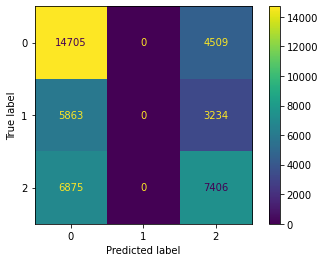

In [414]:
y_pred = model_lstm.predict([train_home, train_away]).argmax(axis=-1)

cm_metrics(y,y_pred, [0,1,2])

In [168]:
#Does NOT predict draws. we MUST try to implement L-BFGS as it seems to work much better in that respect in sklearn  MLP-C

In [ ]:
model_lstm.save('../data/models/LSTM_only_reg')

In [415]:
model_lstm.save('data/HA_LSTM')

INFO:tensorflow:Assets written to: data/HA_LSTM/assets


INFO:tensorflow:Assets written to: data/HA_LSTM/assets
wandb: Network error (ReadTimeout), entering retry loop.


# ajoutons l'historique des rencontre entre les 2 équipes

In [186]:
game_history = pd.read_csv('../data/train_LSTM/game_history_full.csv', index_col = 0,\
    dtype={'game_history_id' : np.int32, 'game_id' : np.int32, 'H_goals' : np.int8, 'H_goals_conceded' : np.int8,\
         'H_HorA' : np.int8, 'H_yellow_cards' : np.int8, 'H_red_cards' : np.int8, 'A_yellow_cards' : np.int8, 'A_red_cards' : np.int8}\
    )

In [189]:
tt = game_history.groupby('game_id')['game_history_id'].count().reset_index()
display(tt.loc[tt.game_history_id>5,:])
game_history.drop(game_history.loc[game_history.game_id.isin( tt.loc[tt.game_history_id>10,'game_history_id'] ), :].index,inplace = True)


,game_id,game_history_id


In [224]:
game_ids = pd.Series(game_history.game_id.unique())

In [222]:
home_history2 = home_history.loc[home_history.game_id.isin(game_ids),:]
away_history2 = away_history.loc[away_history.game_id.isin(game_ids),:]

In [225]:
def make_home_train2(game_id):
    game_history = home_history2.loc[home_history2.game_id == game_id,:].drop(columns=['home_id','game_id'])
    if (n_lines := game_history.shape[0]) == 0:
        return np.zeros((10,6)).astype(np.int8)
    else:
        return np.vstack(( np.zeros((10-n_lines,6)) , np.hstack(( np.ones((n_lines,1)) , np.flip(game_history.to_numpy(),axis=1))) )).astype(np.int8)
train_home2 = game_ids.progress_apply(make_home_train2)
train_home2 = np.stack(train_home2.values)

100%|██████████| 25136/25136 [00:27<00:00, 919.60it/s]


In [226]:
def make_away_train2(game_id):
    game_history = away_history2.loc[away_history2.game_id == game_id,:].drop(columns=['away_id','game_id'])
    if (n_lines := game_history.shape[0]) == 0:
        return np.zeros((10,6)).astype(np.int8)
    else:
        return np.vstack(( np.zeros((10-n_lines,6)) , np.hstack(( np.ones((n_lines,1)) , np.flip(game_history.to_numpy(),axis=1))) )).astype(np.int8)
train_away2 = game_ids.progress_apply(make_away_train2)
train_away2 = np.stack(train_away2.values)

100%|██████████| 25136/25136 [00:27<00:00, 915.34it/s]


In [228]:
train_away2.shape

(25136, 10, 6)

In [193]:
# on rajoute des 0 et des 1 au début de chaque ligne pour indiquer si il y a un match ou pas
# on inverse le game_history avec np.flip(game_history,axis=1) pour classer les matches du plus ancien au plus récent
# Cela dit l'expérience montre que cette inversion n'a pas énormément d'impact sur les performances du modèle... 

def make_history_train(game_id):
    encounter_history = game_history.loc[game_history.game_id == game_id,:].drop(columns=['game_history_id','game_id'])
    if (n_lines := encounter_history.shape[0]) == 0:
        return np.zeros((5,8)).astype(np.int8)
    else:
        return np.vstack(( np.zeros((5-n_lines,8)) , np.hstack(( np.ones((n_lines,1)) , np.flip(encounter_history.to_numpy(),axis=1))) )).astype(np.int8)

In [514]:
train_history_full = games.game_id.progress_apply(make_history_train)

100%|██████████| 42592/42592 [00:41<00:00, 1028.84it/s]


In [516]:
train_history_full = np.stack(train_history_full.values)


In [518]:
train_history_full.shape , train_home.shape, train_away.shape, y.shape

((42592, 5, 8), (42592, 10, 6), (42592, 10, 6), (42592,))

In [ ]:
tt = games.groupby('game_id')['home_club_id'].count().reset_index()
bad_games = tt.loc[tt.home_club_id>1,'game_id'].values

In [334]:
y2 = games.loc[games.game_id.isin(game_ids),:].reset_index(drop = True)
y2.loc[y2.game_id.isin(bad_games),:]

,game_id,home_club_id,away_club_id,home_club_goals,away_club_goals,home_result
22846,3646057,499,58,2,1,0
24968,3646057,499,58,2,1,0


In [335]:
y2.drop(24968,inplace = True)

In [336]:
y2 = game_ids.progress_apply(lambda x: y2.loc[y2.game_id == x,'home_result'].values[0])
y2=y2.values.astype(np.int8)

100%|██████████| 25136/25136 [00:06<00:00, 3702.27it/s]


In [520]:
#X = np.stack((train_away, train_home, train_history_full))
XH_train, XH_test, XA_train, XA_test, XG_train, XG_test, y_train, y_test = train_test_split(train_home, train_away, train_history_full, y, test_size = 0.25, random_state=0, stratify=y)

In [521]:
class DataGenerator2(tf.keras.utils.Sequence):
  def __init__(self, xh_data, xa_data, xg_data, y_data, batch_size):
    self.xh, self.xa, self.xg, self.y = xh_data, xa_data, xg_data, y_data
    self.batch_size = batch_size
    self.num_batches = np.ceil(len(xh_data) / batch_size)
    self.batch_idx = np.array_split(range(len(xh_data)), self.num_batches)

  def __len__(self):
    return len(self.batch_idx)

  def __getitem__(self, idx):
    batch_xh = self.xh[self.batch_idx[idx]]
    batch_xa = self.xa[self.batch_idx[idx]]
    batch_xg = self.xg[self.batch_idx[idx]]
    batch_y = self.y[self.batch_idx[idx]]
    return [batch_xh,batch_xa,batch_xg], batch_y

train_generator2 = DataGenerator2(XH_train, XA_train, XG_train, y_train, batch_size = 128)
val_generator2 = DataGenerator2(XH_test, XA_test, XG_test, y_test, batch_size = 32)

# Modèle
### home_away history pré-entrainé + game_history à entrainer. à voir où on concatène

In [381]:
print(model_lstm.layers[-5])
model_lstm.layers

In [394]:
HA_hist_LSTM = tf.keras.Model(model_lstm.inputs,model_lstm.layers[-5].output)
HA_hist_LSTM.trainable = True
HA_hist_LSTM.layers[0].trainable = False
HA_hist_LSTM.layers[1].trainable = False

In [392]:
HA_hist_LSTM.layers[:2]

In [522]:
home_input = tf.keras.Input(shape = (10,6), name = 'home_train_input')                                  #input 1
away_input = tf.keras.Input(shape = (10,6), name = 'away_train_input')                                  #input 2
LSTM_output = HA_hist_LSTM([home_input,away_input])  

game_input = tf.keras.Input(shape = (5,8), name = 'game_train_input')                                   #input 3
game_LSTM_2 = tf.keras.layers.LSTM(32, kernel_regularizer = L1L2(l1=0.001, l2=0.02), name = 'game_LSTM_2')(game_input)
Dense1 = tf.keras.layers.Dense(128,'relu',name='Dense1')(game_LSTM_2)
#Dense1 = tf.keras.layers.Dropout(0.234375)(Dense1)


concat = tf.keras.layers.Concatenate()([LSTM_output, Dense1])
concat = tf.keras.layers.Dropout(0.2)(concat)

Dense2 = tf.keras.layers.Dense(32,'relu',name='Dense2')(concat)
Dense2 = tf.keras.layers.Dropout(0.125)(Dense2)

Dense_output = tf.keras.layers.Dense(3, 'softmax', name='output')(Dense2)

In [540]:

home_input = tf.keras.Input(shape = (10,6) , name = 'home_train_input')                                   #input 1
home_LSTM_1 = tf.keras.layers.LSTM(32, kernel_regularizer = L1L2(l1=0.01, l2=0.01), name = 'home_LSTM_1')(home_input)

away_input = tf.keras.Input(shape = (10,6), name = 'away_train_input')                                   #input 2
away_LSTM_1 = tf.keras.layers.LSTM(32, kernel_regularizer = L1L2(l1=0.01, l2=0.01), name = 'away_LSTM_1')(away_input)

h_a = tf.keras.layers.Concatenate()([home_LSTM_1,away_LSTM_1])
h_a = tf.keras.layers.Dropout(0.234375)(h_a)
Dense1 = tf.keras.layers.Dense(64,'relu',name='Dense1')(h_a)
Dense1 = tf.keras.layers.Dropout(0.234375)(Dense1)
Dense2 = tf.keras.layers.Dense(16,'relu',name='Dense2')(Dense1)
Dense2 = tf.keras.layers.Dropout(0.125)(Dense2)


game_input = tf.keras.Input(shape = (5,8), name = 'game_train_input')                                   #input 3
game_LSTM_1 = tf.keras.layers.LSTM(32, kernel_regularizer = L1L2(l1=0.001, l2=0.02), name = 'game_LSTM_1')(game_input)


h_a_g = tf.keras.layers.Concatenate()([Dense2,game_LSTM_1])
Dense3 = tf.keras.layers.Dense(64,'relu',name='Dense3')(h_a_g)
Dense3 = tf.keras.layers.Dropout(0.125)(Dense3)



Dense_output = tf.keras.layers.Dense(3, 'softmax', name='output')(Dense3)

In [541]:
model_lstm2 = tf.keras.Model(inputs=[home_input,away_input,game_input], outputs=Dense_output)

In [542]:
opt = Adam(0.0003)
loss = SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()
model_lstm2.compile(optimizer=opt, loss=loss, metrics = [metric])

In [543]:
for weight in weights_list:
    print(len(weight),end='  ')

[len(x) for x in model_lstm2.layers[6].get_weights()]

6  32  128  6  32  128  64  64  64  16  16  3  

[64, 64]

In [544]:
# initialisons les poids de ce modèle avec les poids du dernier modèle
weights_list = model_lstm.get_weights()
model_lstm2.layers[2].set_weights([x for x in weights_list[:3]])
model_lstm2.layers[3].set_weights([x for x in weights_list[3:6]])
model_lstm2.layers[6].set_weights([x for x in weights_list[6:8]])
model_lstm2.layers[8].set_weights([x for x in weights_list[8:10]])





In [545]:
wandb.init(project="foot_LSTM_only_with_regularization2", entity="padda")
model_lstm2.fit(
    train_generator2,
    epochs=150,
    validation_data=val_generator2,
    callbacks=[WandbCallback()])


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁
sparse_categorical_accuracy,▁▃▃▃▄▂▃▄▄▄▅▄▄▄▄▄▅▄▄▅▄▅▅▄▅▅▅▅▆▆▄▅▇▅▃▅▅█▆▆
val_loss,█▄▂▂▂▃▁▁▁▁▂▂▁▁▂▁▂▁▃▂▂▁▃▂▂▂▂█▂▅▃▃▂▃▂▃▃▃▃▃
val_sparse_categorical_accuracy,▅▆▆█▇▃▆▆▅▄▃▇▇▇▇▆▆▆▆▅▇▇▄▅▆▅▆▁▇▅▆▅▆▅▅▅▅▄▅▅
best_epoch,87
best_val_loss,0.98662
epoch,299
loss,0.97869
sparse_categorical_accuracy,0.52861
val_loss,0.99039


Epoch 1/150
250/250 [==============================] - 16s 30ms/step - loss: 1.2841 - sparse_categorical_accuracy: 0.4959 - val_loss: 1.1480 - val_sparse_categorical_accuracy: 0.5199
Epoch 2/150
250/250 [==============================] - 4s 15ms/step - loss: 1.0868 - sparse_categorical_accuracy: 0.5211 - val_loss: 1.0412 - val_sparse_categorical_accuracy: 0.5225
Epoch 3/150
250/250 [==============================] - 4s 18ms/step - loss: 1.0215 - sparse_categorical_accuracy: 0.5209 - val_loss: 1.0070 - val_sparse_categorical_accuracy: 0.5182
Epoch 4/150
250/250 [==============================] - 3s 14ms/step - loss: 1.0005 - sparse_categorical_accuracy: 0.5218 - val_loss: 0.9962 - val_sparse_categorical_accuracy: 0.5193
Epoch 5/150
250/250 [==============================] - 3s 13ms/step - loss: 0.9955 - sparse_categorical_accuracy: 0.5211 - val_loss: 0.9942 - val_sparse_categorical_accuracy: 0.5206
Epoch 6/150
250/250 [==============================] - 4s 14ms/step - loss: 0.9919 - spar

### warm_dragon-4
home_LSTM_2 = tf.keras.layers.LSTM(32, kernel_regularizer = L1L2(l1=0.001, l2=0.02), name = 'home_LSTM_2')(home_input)   
away_LSTM_2 = tf.keras.layers.LSTM(32, kernel_regularizer = L1L2(l1=0.001, l2=0.02), name = 'away_LSTM_2')(away_input)   
game_LSTM_2 = tf.keras.layers.LSTM(32, kernel_regularizer = L1L2(l1=0.001, l2=0.03), name = 'game_LSTM_2')(game_input)   

### 

/var/folders/fw/vk6b0tfx7kvg_95mz0b5mts80000gn/T/ipykernel_17704/1795329321.py:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = { i:cm[i][i]/cm[:,i].sum()  for i in range(len(cm))}
/var/folders/fw/vk6b0tfx7kvg_95mz0b5mts80000gn/T/ipykernel_17704/1795329321.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  F1_score = { i: 2 / (1/recall[i] + 1/precision[i]) for i in range(len(cm))}


accuracy:  0.5208489857250188
Recall: 
 {0: 0.8166111573688593, 1: 0.0, 2: 0.4546218487394958} 
Precision: 
 {0: 0.5256599222832641, 1: nan, 2: 0.5095761381475667} 
F1-score: 
 {0: 0.6396021847232412, 1: nan, 2: 0.48053293856402673}


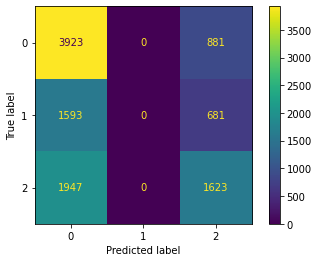

In [539]:
y_pred = model_lstm2.predict([XH_test, XA_test, XG_test]).argmax(axis=-1)

cm_metrics(y_test,y_pred, [0,1,2])

In [546]:
model_lstm2.save('../data/models/H_A_game_history_LSTM')

INFO:tensorflow:Assets written to: ../data/models/H_A_game_history_LSTM/assets


INFO:tensorflow:Assets written to: ../data/models/H_A_game_history_LSTM/assets
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectTimeout), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
